In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

In [2]:
f = uproot.open("FASERnu-skim-29electrons.root")
xarray = f["ntuple"]["x"].array()
print("x")
yarray = f["ntuple"]["y"].array()
print("y")
zarray = f["ntuple"]["z"].array()
print("z")
pxarray = f["ntuple"]["px"].array()
print("px")
pyarray = f["ntuple"]["py"].array()
print("py")
pzarray = f["ntuple"]["pz"].array()
print("pz")
izarray = f["ntuple"]["iz"].array()
print("iz")
truthclusterarray = f["ntuple"]["truthcluster"].array()
print("truthcluster")
rawarray = np.array([xarray,yarray,zarray,pxarray,pyarray,pzarray,izarray,truthclusterarray]).T

x
y
z
px
py
pz
iz
truthcluster


In [3]:
def getClusterArray(array,i): #Get subarray corresponding to electron cluster i
    clsarray = array[array[:,7]==i]
    return clsarray
def getLayerArray(array,j): #Get subarray corresponding to layer j
    clsarray = array[array[:,6]==j]
    return clsarray
def getTrackRow(array,i): # Gets row of data corresponding to ith track
    return array[i:i+1,:]
def getAlphaArray(clsarray,seedtruthclsidx,alphacut):
    dz = 1.3
    seedrow = getClusterArray(rawarray,seedtruthclsidx)[0:1]
    seedxy = seedrow[:,0:2]
    seedpxpy = seedrow[:,3:5]
    seedpz = seedrow[:,5:6]
    xyextrap = seedxy+dz*seedpxpy/seedpz
    xlyrarray = clsarray[:,0:1]
    ylyrarray = clsarray[:,1:2]
    dx = xlyrarray-seedxy[0,0]
    dy = ylyrarray-seedxy[0,1]
    dr = np.sqrt(dx**2+dy**2+dz**2)
    p = np.sqrt(seedpxpy[0,0]**2+seedpxpy[0,1]**2+seedpz**2)
    alpha = np.arccos(np.abs(dx*seedpxpy[0,0]+dy*seedpxpy[0,1]+dz*seedpz)/(dr*p))
    newarray = np.hstack((clsarray,alpha))
    return newarray[newarray[:,8]<alphacut]
def getExtrapArray(trackrow,lyrarray): # take basetrack and extrapolate to single-layer array
    dz = 1.3
    xy = trackrow[:,0:2]
    y = trackrow[0,1]
    pxpy = trackrow[:,3:5]
    py = trackrow[0,4]
    pz = trackrow[0,5]
    xyextrap = xy+dz*pxpy/pz
    xlyrarray = lyrarray[:,0:1]
    ylyrarray = lyrarray[:,1:2]
    zlyrarray = lyrarray[:,2:3]
    pxlyrarray = lyrarray[:,3:4]
    pylyrarray = lyrarray[:,4:5]
    pzlyrarray = lyrarray[:,5:6]
    plyrarray = np.sqrt(pxlyrarray**2+pylyrarray**2+pzlyrarray**2)
    dx = xlyrarray-xyextrap[0,0]
    dy = ylyrarray-xyextrap[0,1]
    drarray = np.sqrt(dx**2+dy**2)
    newarray = np.hstack((lyrarray,drarray))
    p = np.sqrt(pxpy[0,0]**2+pxpy[0,1]**2+pz**2)
    dthetaarray = np.arccos(np.abs(pxlyrarray*pxpy[0,0]+pylyrarray*pxpy[0,1]+pzlyrarray*pz)/(plyrarray*p))
    fullarray = np.hstack((newarray,dthetaarray))
    drcutarray = fullarray[fullarray[:,9]<0.09]
    dthetacutarray = drcutarray[drcutarray[:,10]<0.15]
    finalarray = np.delete(dthetacutarray,9,1)
    finalarray = np.delete(finalarray,9,1)
    return finalarray

In [4]:
def electronClustering(seedtruthclsidx):
    #clsarray = getClusterArray(rawarray,cls)
    clsalphaarray = getAlphaArray(rawarray,seedtruthclsidx,0.1)
    seedbt = getTrackRow(clsalphaarray,0)
    cluster = seedbt # Initialize cluster to seed BT
    idxmax=1
    for lyr in range (1,20):
        alphalyrarray = getLayerArray(clsalphaarray,lyr) # Get all hits in layer1 within cone
        #print("len_alphalyrarray",len(alphalyrarray))
        clslyrarray = getLayerArray(cluster,lyr-1)
        #print("layer",lyr)
        for idx in range(0,idxmax):
            #print("index",idx)
            bt = getTrackRow(clslyrarray,idx)
            extraplyrarray = getExtrapArray(bt,alphalyrarray) # Get which BTs in array should match to bt in layer0
            cluster = np.vstack((cluster,extraplyrarray)) # Add accepted BTs to cluster
            cluster = cluster[np.unique(cluster[:,0:3],axis=0,return_index=True)[1]]
        idxmax = len(getLayerArray(cluster,lyr))
        #print(idxmax)
    return cluster

In [7]:
%%time
for i in range(0,4):
    array = electronClustering(i)
    print(i)
    print(array)

C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in arccos


0
[[-1.0767894e+02 -3.4872955e+01 -6.7729999e+02 ...  1.4000000e+01
   0.0000000e+00  9.7435653e-02]
 [-1.0767645e+02 -3.4838657e+01 -6.7340002e+02 ...  1.7000000e+01
   0.0000000e+00  9.8804042e-02]
 [-1.0767074e+02 -3.4870079e+01 -6.7600000e+02 ...  1.5000000e+01
   0.0000000e+00  9.1184683e-02]
 ...
 [-1.0743713e+02 -3.4815781e+01 -6.7209998e+02 ...  1.8000000e+01
   0.0000000e+00  9.7854458e-02]
 [-1.0743612e+02 -3.4913662e+01 -6.7729999e+02 ...  1.4000000e+01
   0.0000000e+00  9.4451576e-02]
 [-1.0743480e+02 -3.4877323e+01 -6.7600000e+02 ...  1.5000000e+01
   0.0000000e+00  8.9925118e-02]]
1
[[ 5.5077820e+01 -7.2055878e+01 -6.7209998e+02 ...  1.8000000e+01
   1.0000000e+00  9.0499394e-02]
 [ 5.5084133e+01 -7.2010284e+01 -6.7340002e+02 ...  1.7000000e+01
   1.0000000e+00  9.5035642e-02]
 [ 5.5087318e+01 -7.2079948e+01 -6.7209998e+02 ...  1.8000000e+01
   1.0000000e+00  8.3809949e-02]
 ...
 [ 5.5299557e+01 -7.2065369e+01 -6.7729999e+02 ...  1.4000000e+01
   1.0000000e+00  7.9907112e

In [3]:
def getCluster(i): #Get subset of df corresponding to electron cluster i
    dfcluster = df[df["truthcluster"]==i]
    return dfcluster
def getLayer(dfcluster,lyr): #Get DataFrame for truth cluster cls and layer lyr
    dflyr = dfcluster[dfcluster["iz"]==lyr]
    return dflyr

In [4]:
def getTrack(cls,lyr,idx): #Get 1D array for (idx)th track in truth cluster cls and layer lyr
    dflyr = getLayer(cls,lyr)
    dfidx = dflyr.iloc[idx]
    trackarray = dfidx.to_numpy()
    return trackarray
#getTrack(0,0,0) # n.b. all seed BTs have lyr = idx = 0
def getTrackPosition(cls,lyr,idx):
    return getTrack(cls,lyr,idx)[0:3] #position vector of BT hit
def getTrackMomentum(cls,lyr,idx):
    return getTrack(cls,lyr,idx)[3:6] #momentum vector of BT hit

In [5]:
def makeClusterAlpha(i): #Get df subset for electron cluster i and define cone angle alpha relative to primary microtrack
    dfcluster = df[df["truthcluster"]==i]
    seedbtposvec = getTrackPosition(dfcluster,0,0)
    [seedx,seedy,seedz] = seedbtposvec
    [seedpx,seedpy,seedpz] = getTrackMomentum(dfcluster,0,0)
    seedp = np.sqrt(seedpx**2+seedpy**2+seedpz**2)
    dx = dfcluster["x"]-seedx
    dy = dfcluster["y"]-seedy
    dz = dfcluster["z"]-seedz
    dr = np.sqrt(dx**2+dy**2+dz**2)
    p = np.sqrt(dfcluster["px"]**2+dfcluster["py"]**2+dfcluster["pz"]**2)
    dfcluster["alpha"] = np.arccos(np.abs(dx*dfcluster["px"]+dy*dfcluster["py"]+dz*dfcluster["pz"])/(dr*p))
    return dfcluster

In [6]:
def makeDfAlpha(i): #Get df subset for electron cluster i and define cone angle alpha relative to primary microtrack
    dfcluster = df
    dfclusteri = df[df["truthcluster"]==i]
    seedbtposvec = getTrackPosition(dfclusteri,0,0)
#    print(seedbtposvec)
    [seedx,seedy,seedz] = seedbtposvec
    [seedpx,seedpy,seedpz] = getTrackMomentum(dfclusteri,0,0)
    seedp = np.sqrt(seedpx**2+seedpy**2+seedpz**2)
    dx = dfcluster["x"]-seedx
    dy = dfcluster["y"]-seedy
    dz = dfcluster["z"]-seedz
    dr = np.sqrt(dx**2+dy**2+dz**2)
    p = np.sqrt(dfcluster["px"]**2+dfcluster["py"]**2+dfcluster["pz"]**2)
    dfcluster["alpha"] = np.arccos(np.abs(dx*dfcluster["px"]+dy*dfcluster["py"]+dz*dfcluster["pz"])/(dr*p))
    return dfcluster

In [24]:
a = makeClusterAlpha(1)
b = makeDfAlpha(1)
print(len(a[a["alpha"]<0.1]),len(b[b["alpha"]<0.1]))

C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


[  55.19545364  -72.06469727 -695.5       ]
32781 101264


In [8]:
def getLayerAlphaCut(cls,lyr): #Get DataFrame for truth cluster cls and layer lyr
    if lyr==0:
        dfclsalphacut = cls.iloc[0:1]
        return dfclsalphacut
    else:
        dfclsalphacut = cls[cls["alpha"]<0.1] # Apply cone angle cut
        dflyr = dfclsalphacut[dfclsalphacut["iz"]==lyr] # Select MTs passing cut in layer lyr
        return dflyr

In [10]:
def makeClusterExtrap(cls,lyr,idx): #Get df subset for electron cluster i and define dr, dtheta for each track rel to (lyr,idx)
    #dfcluster = df[df["truthcluster"]==i]
    dfcluster = cls[cls["alpha"]<0.1]
    [x,y,z] = getTrackPosition(cls,lyr,idx)
    [px,py,pz] = getTrackMomentum(cls,lyr,idx)
    dz = 1.3
    xex = x+dz*px/pz
    yex = y+dz*py/pz
    zex = z+dz
    dfcluster["dr"] = np.sqrt((dfcluster["x"]-xex)**2+(dfcluster["y"]-yex)**2)
    dfcluster["dtheta"] = np.arccos(np.abs(px*dfcluster["px"]+py*dfcluster["py"]+pz*dfcluster["pz"])/np.sqrt((dfcluster["px"]**2+dfcluster["py"]**2+dfcluster["pz"]**2)*(px**2+py**2+pz**2)))
    dfcluster = dfcluster[dfcluster["iz"]==lyr+1]
    return dfcluster[np.logical_and(dfcluster["dr"]<0.09,dfcluster["dtheta"]<0.15)]

In [11]:
%%time
#list_signtuples = list(zip(xlist,ylist,zlist,pxlist,pylist,pzlist,izlist,truthclusterlist)) #Make ntuple list for pandas df
#df = pd.DataFrame(list_signtuples,columns=['x','y','z','px','py','pz','iz','truthcluster']) #DataFrame of raw variables
#dfclusters = pd.DataFrame()
for cls in range(0,29): # Make 29 clusters
    dfalpha = makeClusterAlpha(cls)
    dfalphacut = getLayerAlphaCut(dfalpha,0)
    dfalphacut["dr"] = 0
    dfalphacut["dtheta"] = 0
    dfalphacut["cluster"] = cls
    for i in range(0,50):
        jmax = len(dfalphacut[dfalphacut["iz"]==i])
        print(cls,jmax)
        for j in range(0,jmax):
            dfextrap = makeClusterExtrap(dfalpha,i,j)
            dfextrap["cluster"] = cls
            dfalphacut = dfalphacut.append(dfextrap)
            dfalphacut.drop_duplicates(subset=["x","y","z","px","py","pz"],inplace=True)
    dfclusters = dfclusters.append(dfalphacut)
dfclusters

C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

0 1
0 1
0 1
0 1
0 5
0 5
0 10
0 11
0 15
0 20
0 20
0 24
0 25
0 35
0 46
0 54
0 61
0 65
0 110
0 146
0 176
0 211
0 231
0 260
0 285
0 311
0 357
0 390
0 396
0 421
0 444
0 459
0 488
0 497
0 527
0 556
0 586
0 599
0 614
0 653
0 662
0 633
0 647
0 674
0 607
0 626
0 596
0 586
0 548
0 480
1 1
1 1
1 3
1 3
1 3
1 7
1 8
1 8
1 12
1 11
1 18
1 28
1 36
1 56
1 69
1 89
1 87
1 102
1 110
1 129
1 151
1 167
1 190
1 203
1 206
1 223
1 251
1 276
1 303
1 330
1 363
1 379
1 403
1 411
1 451
1 451
1 464
1 494
1 470
1 450
1 439
1 444
1 429
1 431
1 419
1 388
1 391
1 400
1 379
1 304
2 1
2 3
2 3
2 5
2 7
2 14
2 18
2 29
2 38
2 61
2 88
2 113
2 130
2 160
2 187
2 205
2 254
2 286
2 304
2 350
2 370
2 412
2 437
2 459
2 466
2 469
2 473
2 536
2 559
2 550
2 558
2 588
2 607
2 608
2 561
2 510
2 535
2 542
2 547
2 570
2 543
2 514
2 484
2 501
2 466
2 452
2 419
2 418
2 394
2 406
3 1
3 3
3 2
3 3
3 5
3 5
3 5
3 5
3 7
3 10
3 13
3 13
3 19
3 24
3 23
3 27
3 38
3 44
3 57
3 81
3 96
3 117
3 122
3 142
3 168
3 191
3 215
3 249
3 289
3 318
3 334
3 378
3 3

KeyboardInterrupt: 

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm
from collections import OrderedDict
%matplotlib inline
def plot_cluster(dfcluster):
    dZ = 1
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    # mind the order!
    ax.set_title("Clustering Event Display")
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(-696.5,-600)
    ax.set_ylim(-125,125)
    ax.set_zlim(-100,100)
    for clusteridx in range(0,29):
        df = dfcluster[dfcluster["cluster"]==clusteridx]
        df["tx"] = df["px"]/df["pz"]
        df["ty"] = df["py"]/df["pz"]
        # mind the order!
        d0 = pd.DataFrame([
                    df['z'],
                    df['x'],
                    df['y']],
                    index=['z', 'x', 'y']).T
        numtracks = d0.shape[0]
        dd = pd.DataFrame([
                df['tx']*dZ,
                df['ty']*dZ],
                index=['x', 'y']).T
        dd.insert(loc=0, column='z', value=dZ)
        d1 = d0 + dd
        # print d0, d1
        np.random.seed(clusteridx)
        C = (np.random.uniform(),np.random.uniform(),np.random.uniform())
        lc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)
        ax.view_init(azim=-50, elev=10)
        ax.add_collection3d(lc)

C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\Added_Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


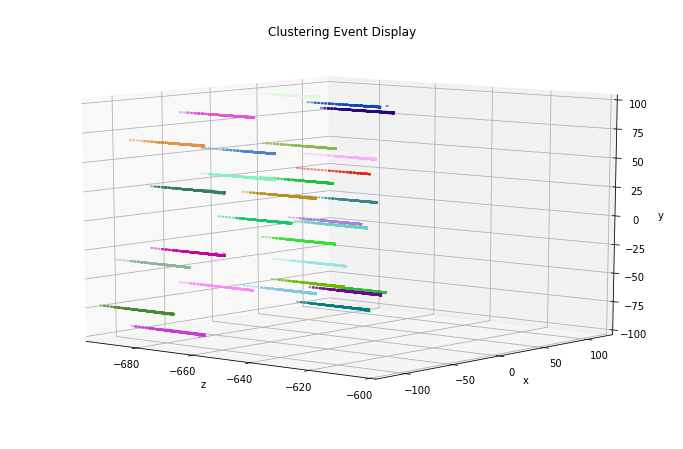

In [50]:
plot_cluster(dfclusters)

In [12]:
def getTrackAlphaCut(cls,lyr,idx): #Get 1D array for (idx)th track in truth cluster cls and layer lyr
    dflyr = getLayerAlphaCut(cls,lyr) # Get all tracks in cluster cls and layer lyr passing alpha cut
    dfidx = dflyr.iloc[idx] # Get position, momentum, index, truth cluster, and alpha of track
    trackarray = dfidx.to_numpy()
    return trackarray
def getTrackPositionAlphaCut(cls,lyr,idx):
    return getTrackAlphaCut(cls,lyr,idx)[0:3] #position vector of BT hit
def getTrackMomentumAlphaCut(cls,lyr,idx):
    return getTrackAlphaCut(cls,lyr,idx)[3:6] #momentum vector of BT hit

In [13]:
%%time
getTrackAlphaCut(clsalpha,0,0)

Wall time: 3 ms


array([ 1.10664726e+02,  7.80776672e+01, -6.95500000e+02,  6.88693094e+00,
        7.94478130e+00,  1.00145619e+06,  0.00000000e+00,  0.00000000e+00,
                   nan])

In [14]:
def extrap(cls,lyr,idx): # Function to extrapolate BT forward by one layer
    trackposition = getTrackPositionAlphaCut(cls,lyr,idx)
    trackmomentum = getTrackMomentumAlphaCut(cls,lyr,idx)
    dz = 1.3 # 1.3mm from izsub=0 of layer k to izsub=0 of layer k+1
    trackx = trackposition[0]
    tracky = trackposition[1]
    trackz = trackposition[2]
    trackpx = trackmomentum[0]
    trackpy = trackmomentum[1]
    trackpz = trackmomentum[2]
    xextrap = trackx+dz*trackpx/trackpz # Extrapolated x position
    yextrap = tracky+dz*trackpy/trackpz # Extrapolated y position
    zextrap = trackz+dz # Extrapolated z position
    return np.array([xextrap,yextrap,zextrap])

In [15]:
%%time
extrap(clsalpha,0,0) # Test

Wall time: 4.99 ms


array([ 110.6647352 ,   78.07767755, -694.2       ])

In [16]:
%%time
getTrackPositionAlphaCut(clsalpha,1,0)

Wall time: 120 ms


array([ 110.66471863,   78.07767487, -694.20001221])

In [17]:
def matchbasetracks(clsalpha,startlyr,idx1,idx2):
    extrapposvec = extrap(clsalpha,startlyr,idx1)
    trackposvec = getTrackPositionAlphaCut(clsalpha,startlyr+1,idx2)
    deltaposvec = extrapposvec-trackposvec
    deltaposmag = np.linalg.norm(deltaposvec)
    seedmomvec = getTrackMomentumAlphaCut(clsalpha,startlyr,idx1)
    seedmommag = np.linalg.norm(seedmomvec)
    trackmomvec = getTrackMomentumAlphaCut(clsalpha,startlyr+1,idx2)
    trackmommag = np.linalg.norm(trackmomvec)
    deltatheta = np.arccos(np.abs(np.dot(seedmomvec,trackmomvec))/(seedmommag*trackmommag))
    return np.array([deltaposmag,deltatheta])

In [18]:
%%time
matchbasetracks(clsalpha,1,0,0)

Wall time: 149 ms


array([1.25936252e-05, 6.12749446e-06])

In [170]:
def electronCluster(d,deltarmax,deltathetamax): # Returns cluster of depth d with clustering cuts deltarmax, deltathetamax
    dfalpha = makeClusterAlpha(0) # Computationally expensive, call once only!
    dfcluster = getLayerAlphaCut(dfalpha,0) # Initialize to cluster with seed BT only
    dfclusternextlyr = dfcluster # initialize to cluster with seed BT only
    print(dfcluster)
    for lyr in range(0,d):
        layerlength = len(dfclusternextlyr)
        nextlayerlength = len(getLayerAlphaCut(dfalpha,lyr+1))
        print(layerlength,nextlayerlength)
        for idx1 in range(0,layerlength):
            for idx2 in range(0,nextlayerlength):
                deltaarray = matchbasetracks(dfalpha,lyr,idx1,idx2)
                print("layer ",lyr,"idx1 ",idx1,"idx2 ",idx2,deltaarray)
                if deltaarray[0]<deltarmax:
                    if deltaarray[1]<deltathetamax:
                        dfcluster = dfcluster.append(getLayerAlphaCut(dfalpha,lyr+1).iloc[idx2])
        dfcluster.drop_duplicates(inplace=True)
        dfclusternextlyr = dfcluster[dfcluster["iz"]==lyr+1]
        print(dfclusternextlyr)
    return dfcluster

In [22]:
%%time
clusterdataframe2 = electronCluster(2,0.09,0.15)

            x          y      z        px        py            pz   iz  \
0  110.664726  78.077667 -695.5  6.886931  7.944781  1.001456e+06  0.0   

   truthcluster  alpha  
0           0.0    NaN  
1 3
layer  0 idx1  0 idx2  0 [2.07547339e-05 1.66933114e-05]
layer  0 idx1  0 idx2  1 [2.73037140e-05 1.86675393e-05]
layer  0 idx1  0 idx2  2 [7.66673081e-05 1.22459407e-04]
                 x          y           z        px        py             pz  \
1       110.664719  78.077675 -694.200012 -7.643328  3.953484  800737.750000   
321507  110.664719  78.077660 -694.200012  1.876537 -3.581063  334968.562500   
434850  110.664810  78.077667 -694.200012  6.576544 -0.584776   51457.128906   

         iz  truthcluster     alpha  
1       1.0           0.0  0.000004  
321507  1.0           0.0  0.000012  
434850  1.0           0.0  0.000064  
3 7
layer  1 idx1  0 idx2  0 [1.25936252e-05 6.12749446e-06]
layer  1 idx1  0 idx2  1 [5.72263126e-05 4.08260164e-05]
layer  1 idx1  0 idx2  2 [0.0001769

In [52]:
clusterdataframe2

x          y           z         px         py            pz  \
0       110.664726  78.077667 -695.500000   6.886931   7.944781  1.001456e+06   
1       110.664719  78.077675 -694.200012  -7.643328   3.953484  8.007378e+05   
321507  110.664719  78.077660 -694.200012   1.876537  -3.581063  3.349686e+05   
434850  110.664810  78.077667 -694.200012   6.576544  -0.584776  5.145713e+04   
2       110.664703  78.077682 -692.900024 -10.100178   6.196869  7.055368e+05   
...            ...        ...         ...        ...        ...           ...   
291503  110.652298  78.180214 -682.500000  -7.419811  20.973793  2.734838e+02   
294243  110.573280  78.186310 -682.500000  -6.681746  -1.802734  8.607710e+01   
451321  111.029266  78.222710 -682.500000  11.755202   8.310030  1.196479e+02   
452625  110.331543  77.997559 -682.500000  -7.767421   2.477440  1.635165e+02   
452706  110.304420  78.011246 -682.500000   0.414763  -0.620615  1.060770e+01   

          iz  truthcluster     alpha  
0        0.0           0.0       NaN  
1        1.0           0.0  0.000004  
321507   1.0           0.0  0.000012  
434850   1.0           0.0  0.000064  
2        2.0           0.0  0.000006  
...      ...           ...       ...  
291503  10.0           0.0  0.073435  
294243  10.0           0.0  0.076258  
451321  10.0           0.0  0.090689  
452625  10.0           0.0  0.030504  
452706  10.0           0.0  0.085410  

[340 rows x 9 columns]

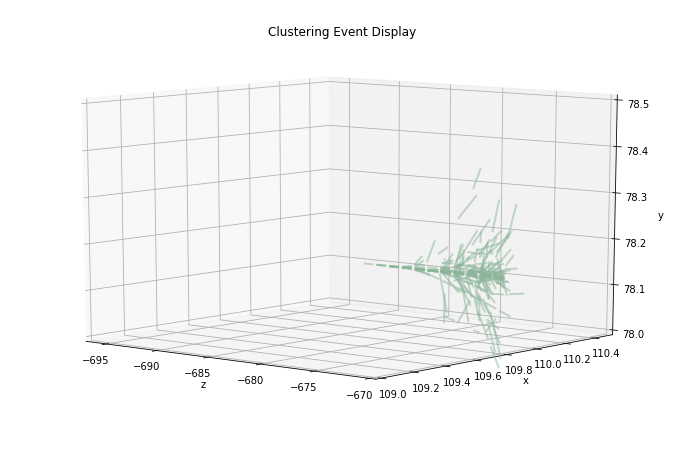

In [175]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm
from collections import OrderedDict
%matplotlib inline
def plot_cluster(dfcluster):
    dZ = 1
    clusteridx = 0 # Temporary
    df = dfcluster[dfcluster["truthcluster"]==clusteridx]
    df["tx"] = df["px"]/df["pz"]
    df["ty"] = df["py"]/df["pz"]
    # mind the order!
    d0 = pd.DataFrame([
                df['z'],
                df['x'],
                df['y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['tx']*dZ,
            df['ty']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    np.random.seed(clusteridx)
    C = (np.random.uniform(),np.random.uniform(),np.random.uniform())
    lc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-50, elev=10)
    ax.add_collection3d(lc)
    
    # mind the order!
    ax.set_title("Clustering Event Display")
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(-696.5,-670)
    ax.set_ylim(109,110.5)
    ax.set_zlim(78,78.5)
plot_cluster(dfalphacut)